<a href="https://colab.research.google.com/github/kairamilanifitria/Automated-Speech-Recognition-and-Intent-Classification-MIND14/blob/main/1.%20Build%20ASR-Whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets[audio]
!pip install evaluate
!pip install jiwer
!pip install datasets --upgrade
!pip install rouge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import IPython.display as ipd
import torch
import transformers
import datasets
import librosa
import re
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
import nltk
import librosa.display

from IPython.display import display as ipd
from IPython.display import HTML
from datasets import load_dataset, ClassLabel, Audio # Remove load_metric from here
from evaluate import load # Import load from evaluate instead
from transformers import WhisperConfig, WhisperProcessor, WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, DataCollator
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, Trainer, TrainingArguments
from transformers import pipeline
from transformers.utils import send_example_telemetry

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import AdamW
from datasets import DatasetDict
from datasets import concatenate_datasets

from rouge import Rouge

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False  --include 'en-US/*'

minds_enUS = load_dataset('./en-US', split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 1 files:   0% 0/1 [00:00<?, ?it/s]Downloading 'en-US/train/0000.parquet' to '.cache/huggingface/download/en-US/train/0000.parquet.07f4309eeb2eaec72b31960d6408544b17a4a08d8c49ad41f2b6f2c79962108b.incomplete'

0000.parquet:   0% 0.00/34.2M [00:00<?, ?B/s]
0000.parquet: 100% 34.2M/34.2M [00:00<00:00, 166MB/s]
Download complete. Moving file to en-US/train/0000.parquet
Fetching 1 files: 100% 1/1 [00:00<00:00,  2.27it/s]
/content


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(minds_enUS)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})


In [ ]:
merged_dataset = concatenate_datasets([minds_enUS])

print(merged_dataset)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})


In [ ]:
intent_classes = [
    {'index': 0, 'name': 'abroad'},
    {'index': 1, 'name': 'adress'},
    {'index': 2, 'name': 'app_error'},
    {'index': 3, 'name': 'atm_limit'},
    {'index': 4, 'name': 'balance'},
    {'index': 5, 'name': 'business_loan'},
    {'index': 6, 'name': 'card_issues'},
    {'index': 7, 'name': 'cash_deposite'},
    {'index': 8, 'name': 'direct_debit'},
    {'index': 9, 'name': 'freeze'},
    {'index': 10, 'name': 'latest_transactions'},
    {'index': 11, 'name': 'joint_account'},
    {'index': 12, 'name': 'high_value_payment'},
    {'index': 13, 'name': 'pay_bill'}
]

In [ ]:
def plot_label_distribution(dataset):
    # Extract intent_class labels
    labels = dataset['intent_class']

    # Count the frequency of each label
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Sort labels by their counts in descending order
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_labels = [{'name': intent_classes[label[0]]['name'], 'index': intent_classes[label[0]]['index'], 'count': label[1]} for label in sorted_labels]

    # Create x-axis labels combining name and index
    x_labels = [f"{label['name']} ({label['index']})" for label in sorted_labels]
    counts = [label['count'] for label in sorted_labels]

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(x_labels, counts, color='skyblue')
    plt.xlabel('Intent Class')
    plt.ylabel('Frequency')
    plt.title('Distribution of Intent Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


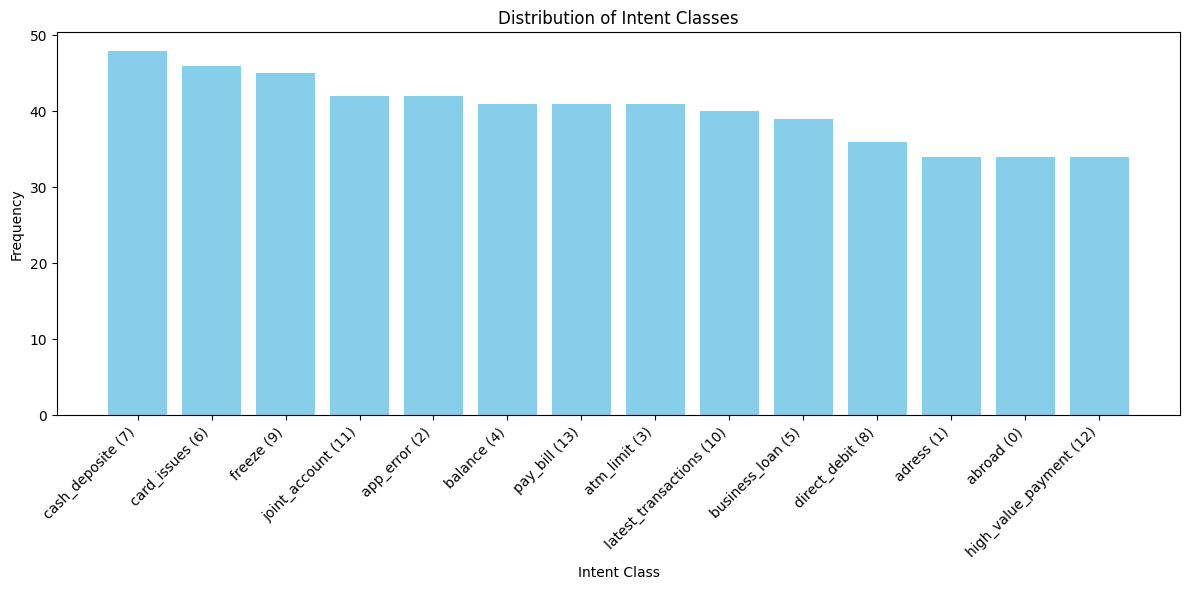

In [ ]:
plot_label_distribution(merged_dataset)

In [ ]:
import IPython.display as ipd
from IPython.core.display import display

def plot_waveform_and_spectrogram(dataset, intent_class, name_intent):
    # Filter dataset for a specific intent_class
    filtered_data = dataset.filter(lambda example: example['intent_class'] == intent_class)

    # Take the first audio sample for the given intent_class
    sample = filtered_data[0]

    # Extract audio array and sampling rate
    audio_array = sample['audio']['array']
    sr = sample['audio']['sampling_rate']

    # display(Audio(sample['audio']))
    ipd.Audio(data=np.asarray(sample['audio']['array']), rate=8000)

    print("transcription: ", sample['transcription'])

    # Plot Waveform
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    librosa.display.waveshow(audio_array, sr=sr)
    plt.title(f'Waveform for intent_class: {intent_class} {name_intent}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Compute and plot Spectrogram
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    X = librosa.stft(audio_array)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram for intent_class: {intent_class} {name_intent}')

    plt.tight_layout()
    plt.show()


Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  yes I'm going to be traveling to the United Kingdom for a couple of weeks next month I need to know if I can use my card from from my bank account while I'm in Europe


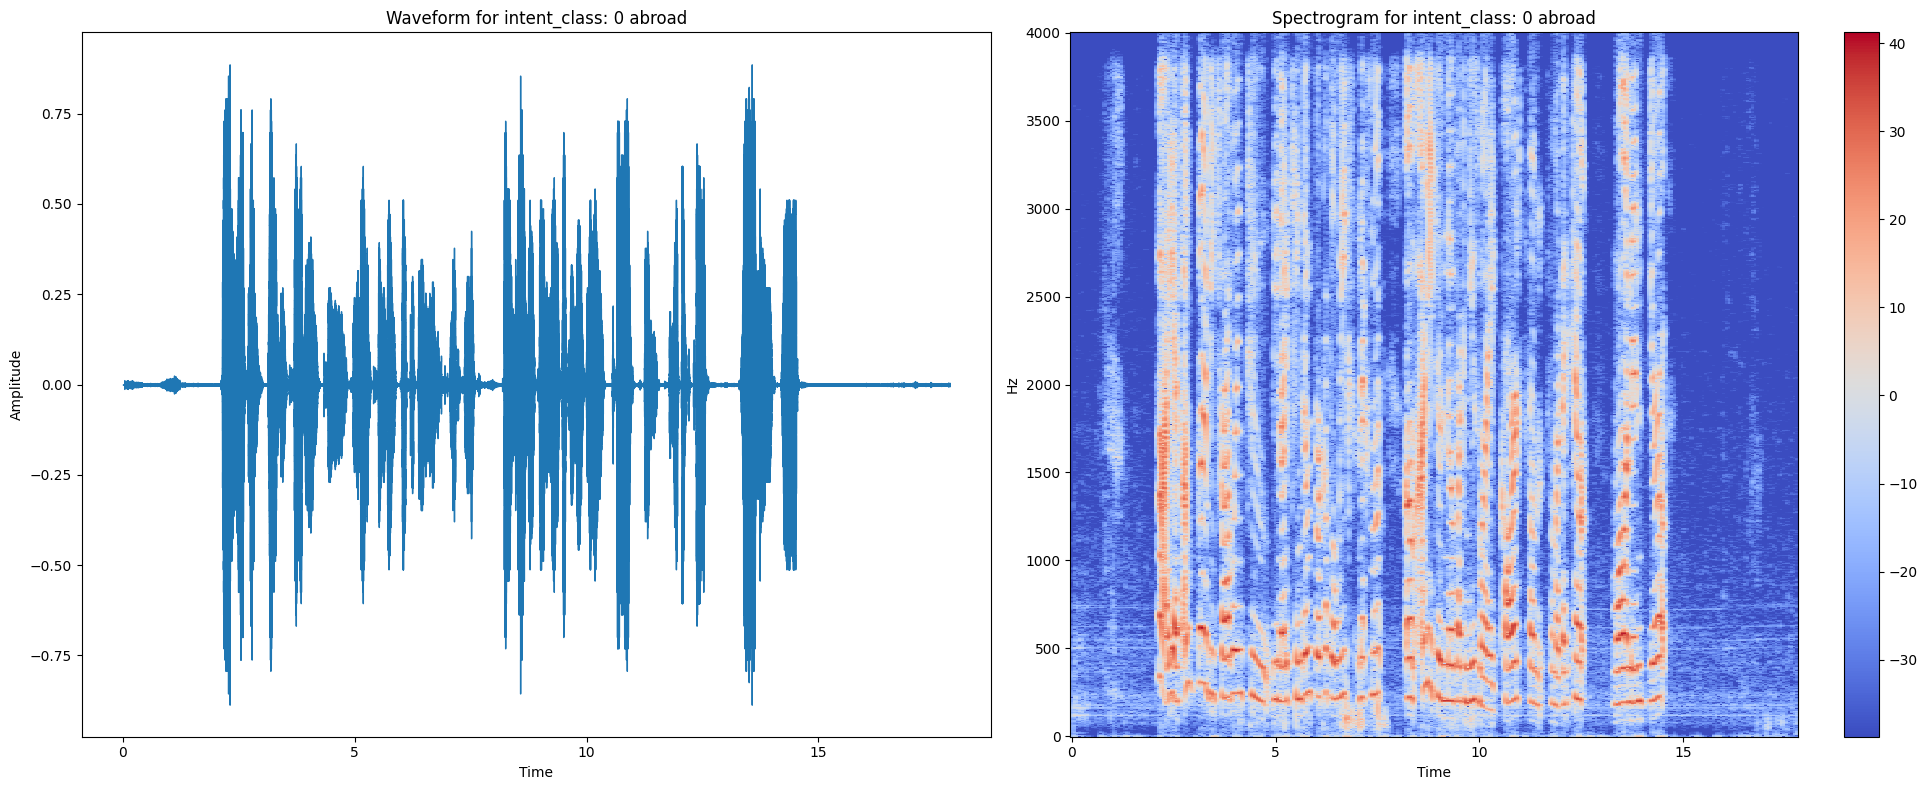

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  hi yes I like to change my address


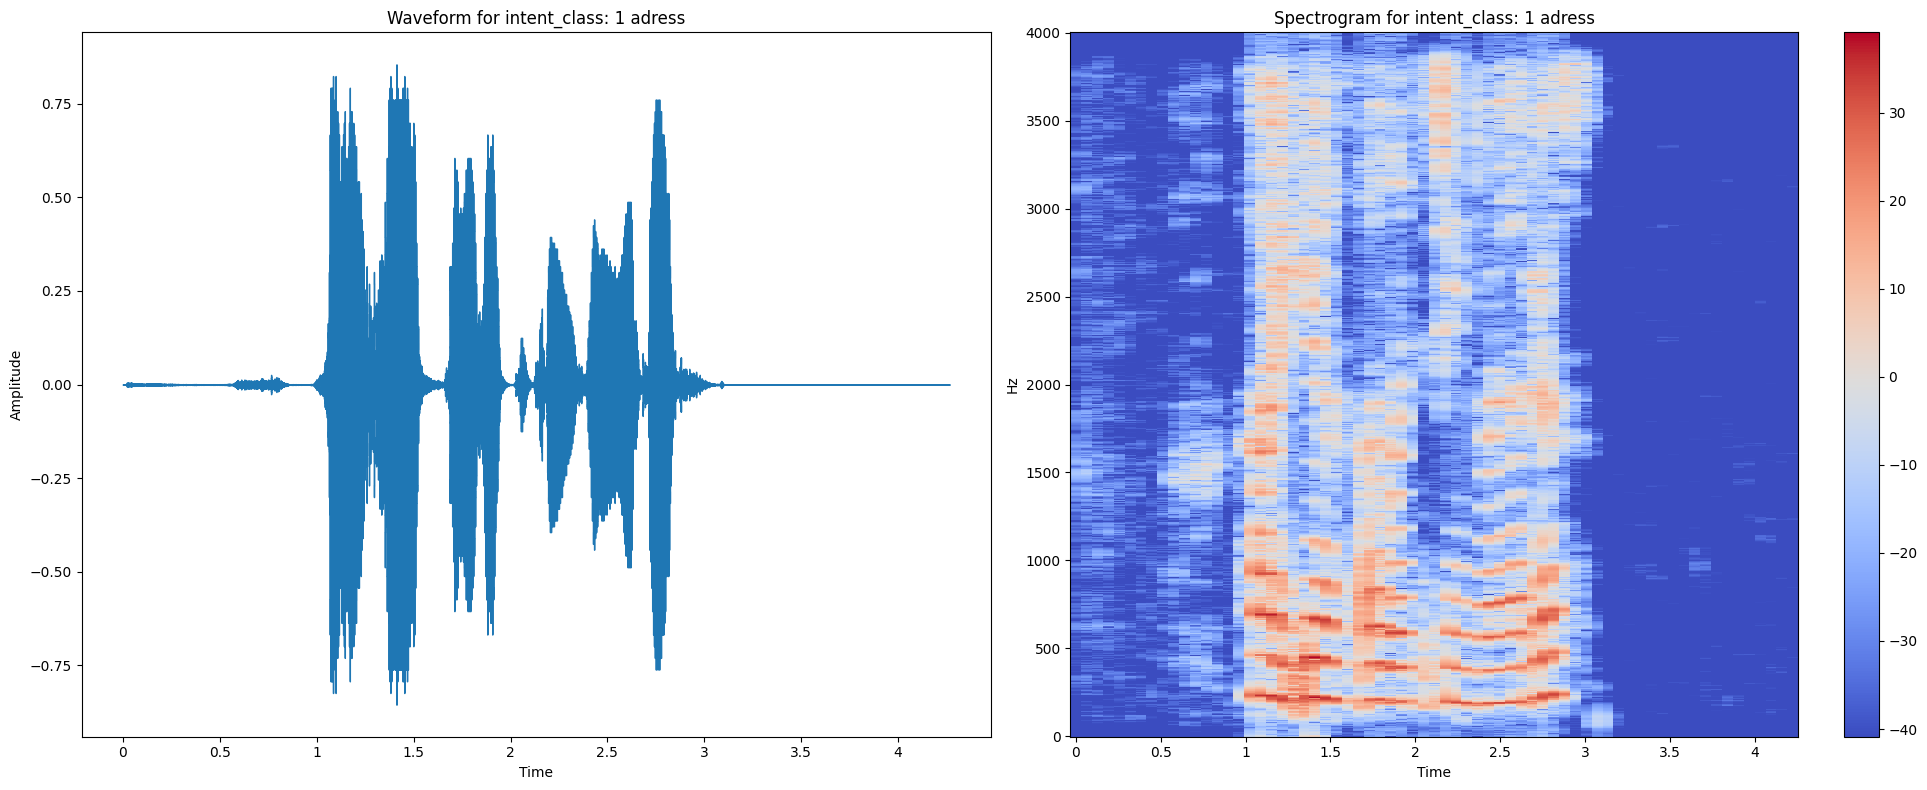

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  high on the app isn't loading information


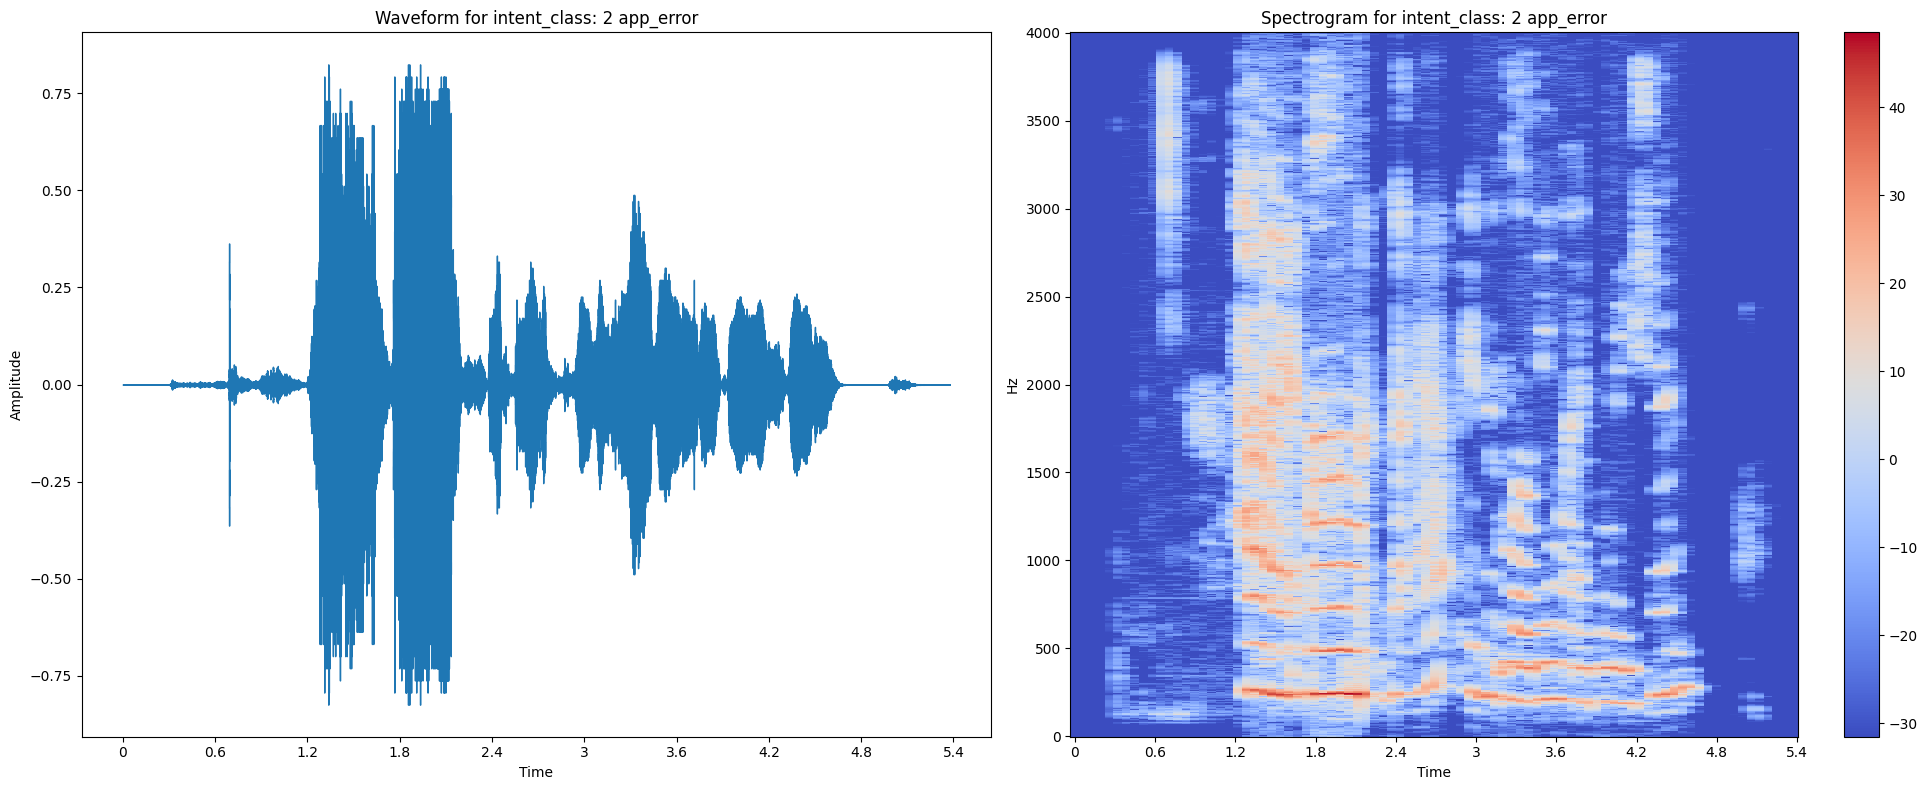

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  how much money can I withdraw per day from the ATM


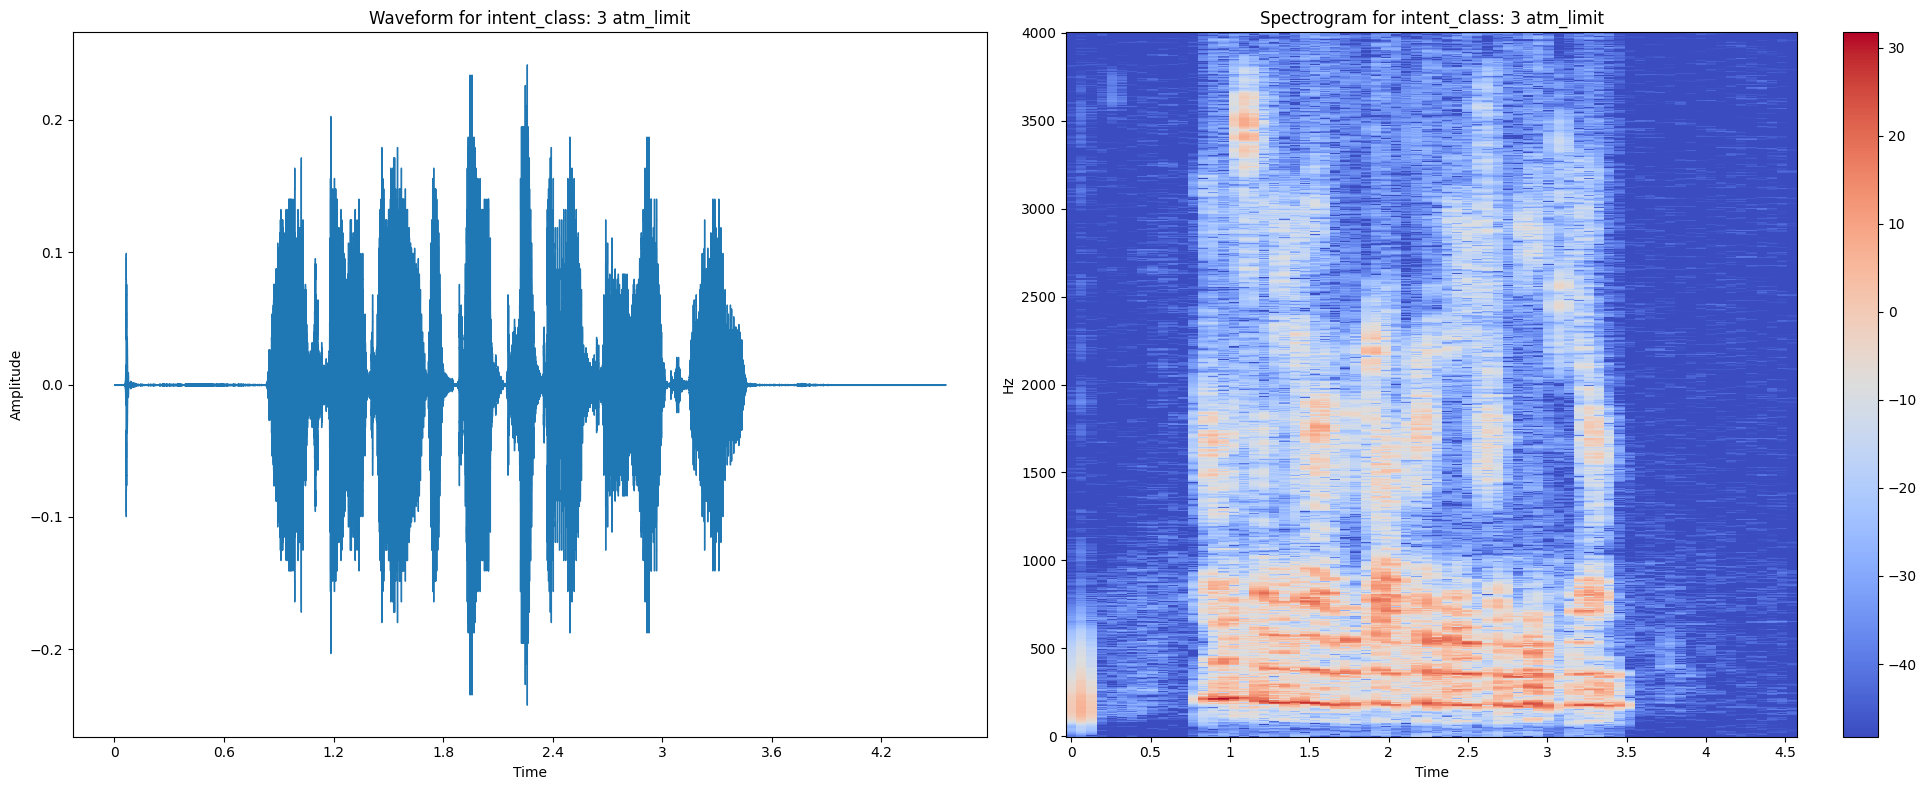

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  what is my account balance


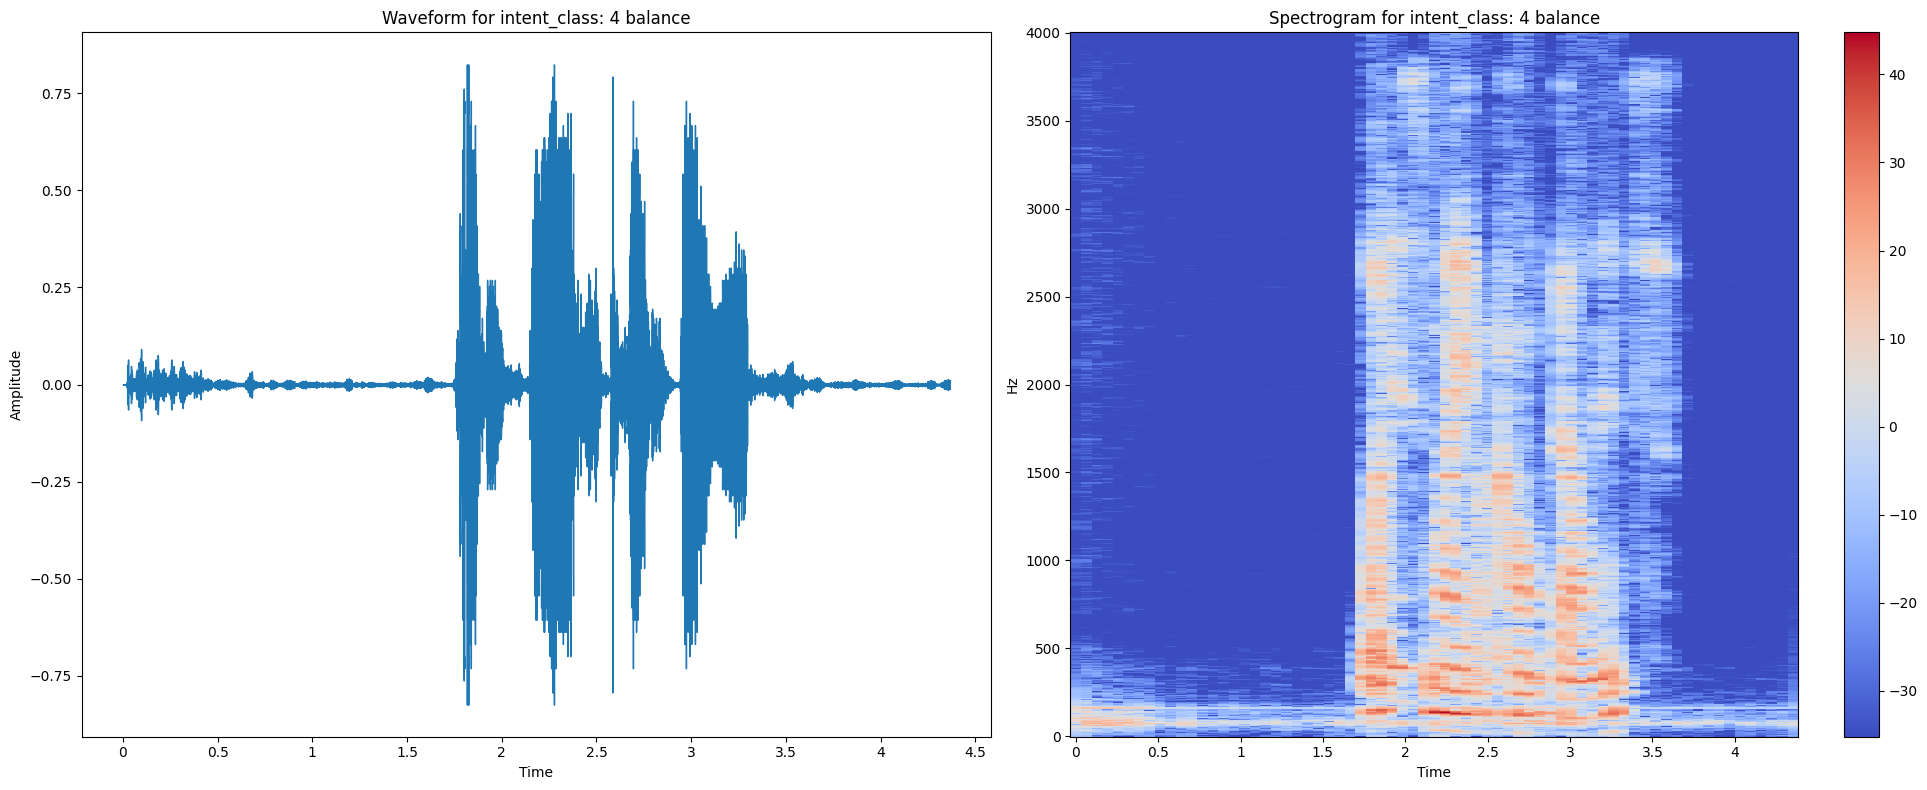

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  I'm calling to inquire about a business loan


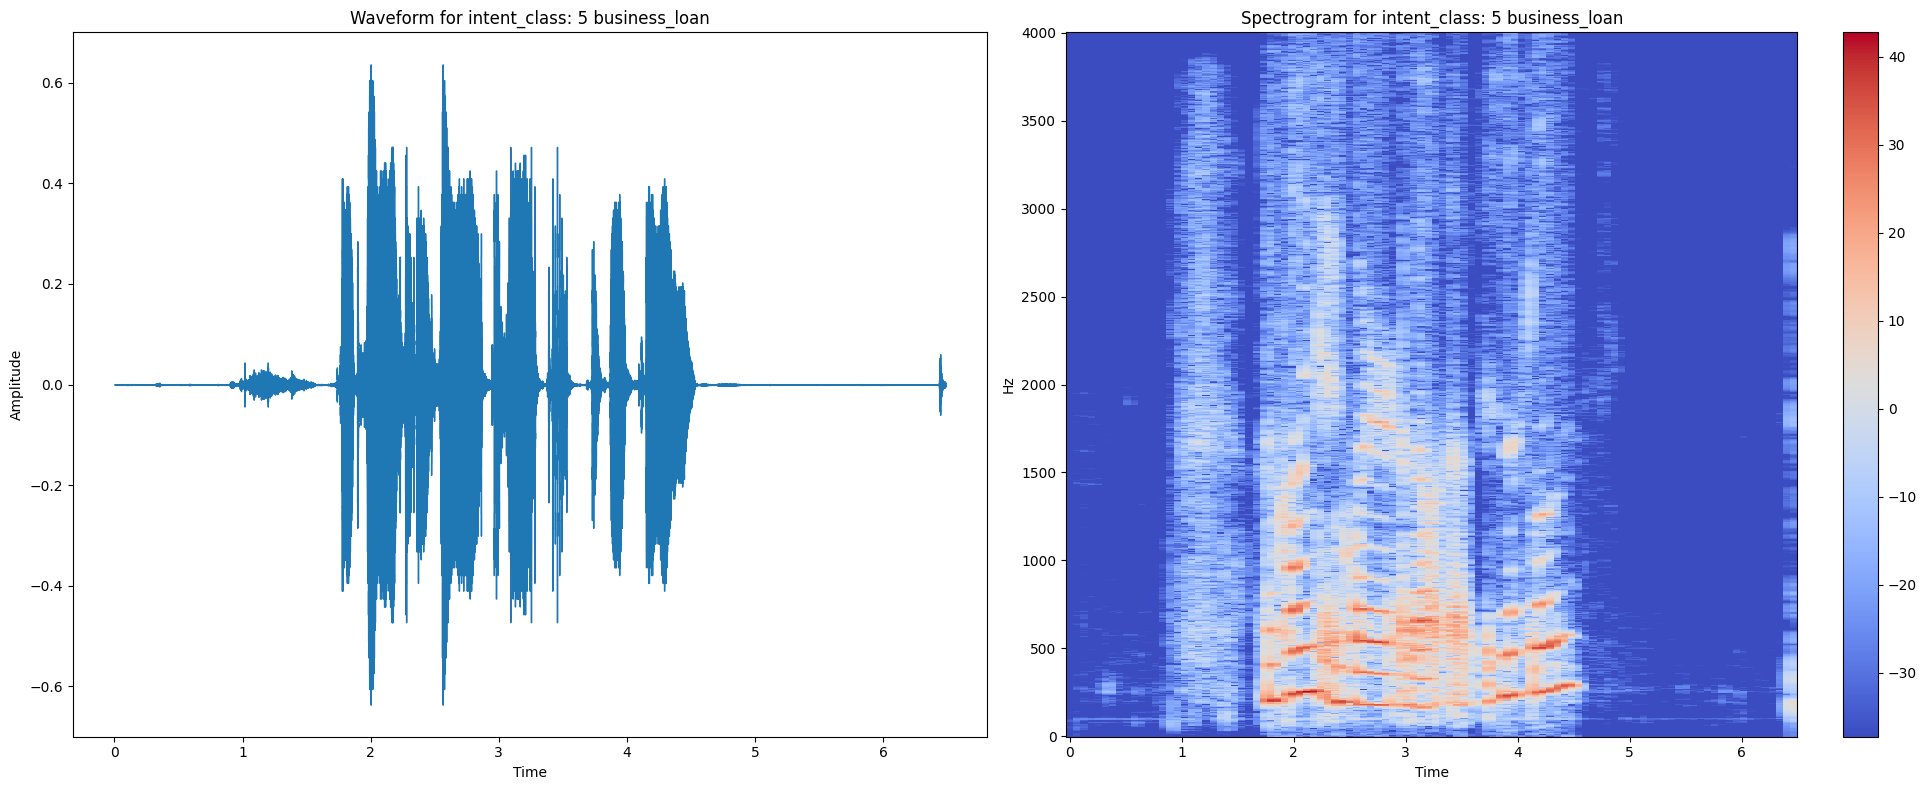

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  I'm trying to say something is my car doesn't seem to work whenever I called do it it doesn't actually work


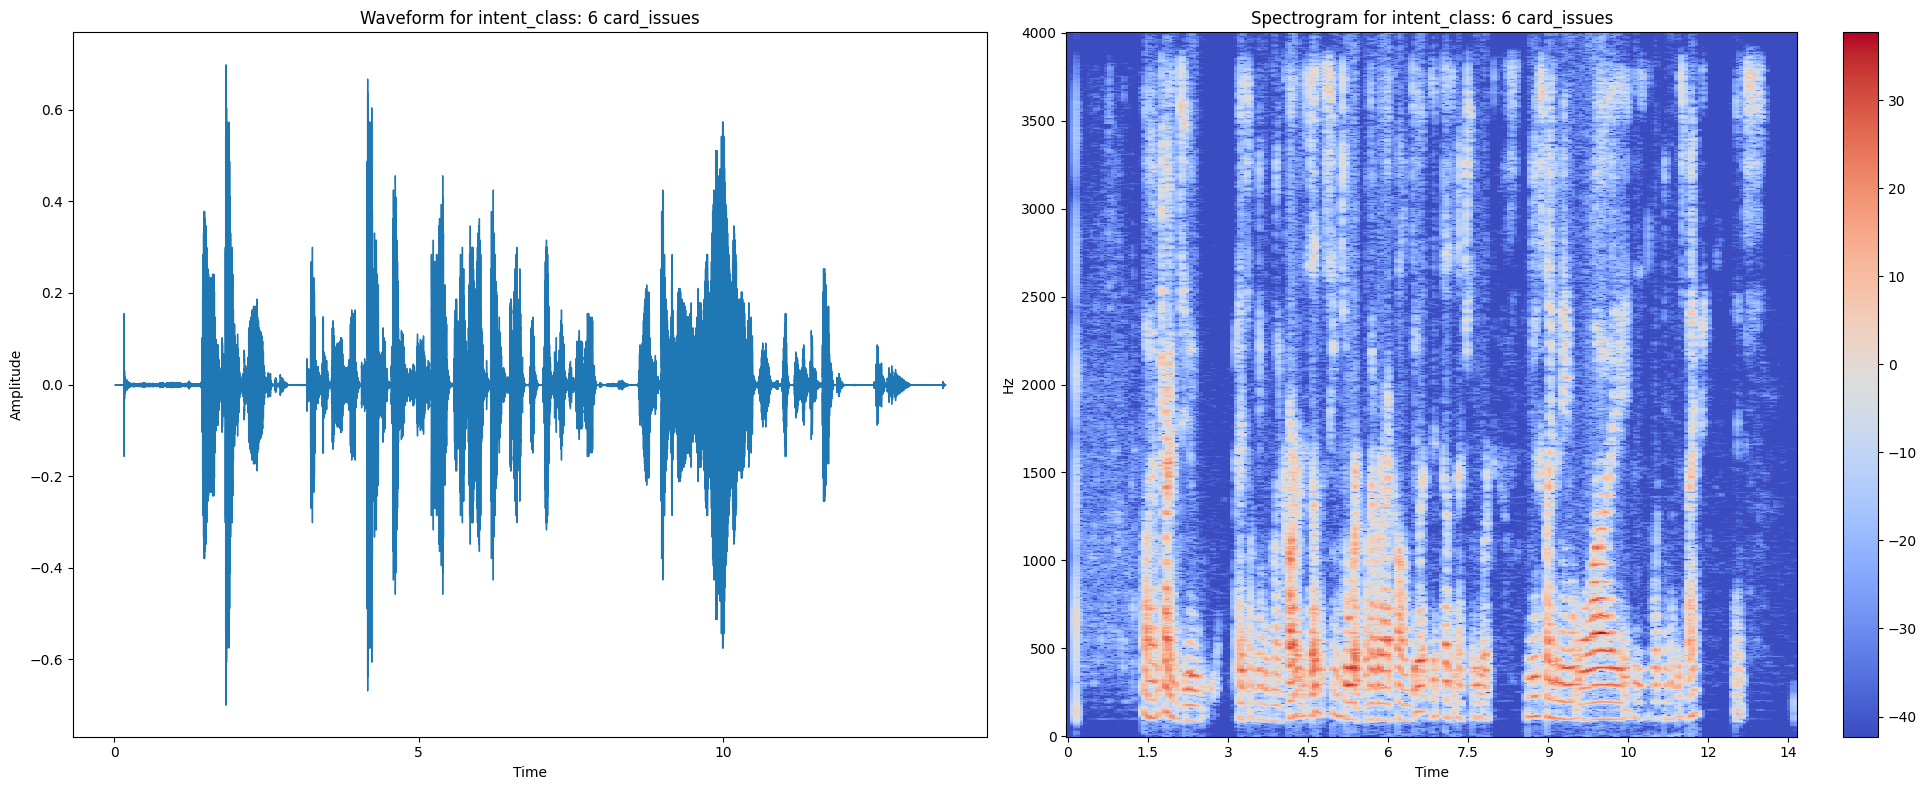

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  transfer money to the account


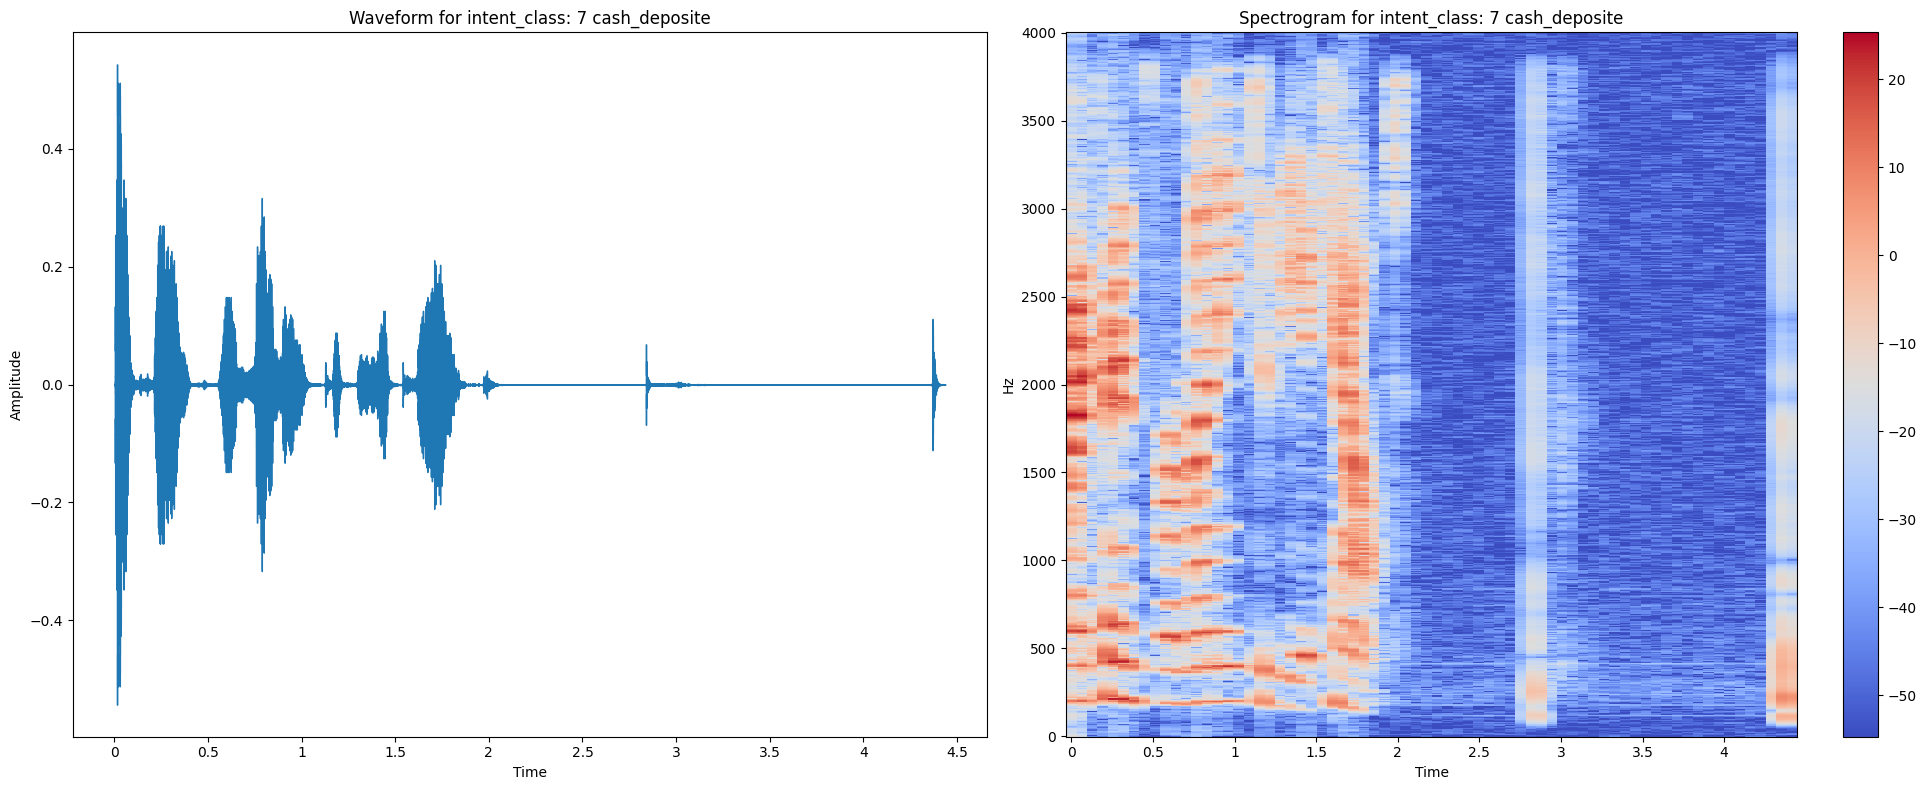

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  I'm having trouble understanding what a direct debit is to provide through Clarity and information for me


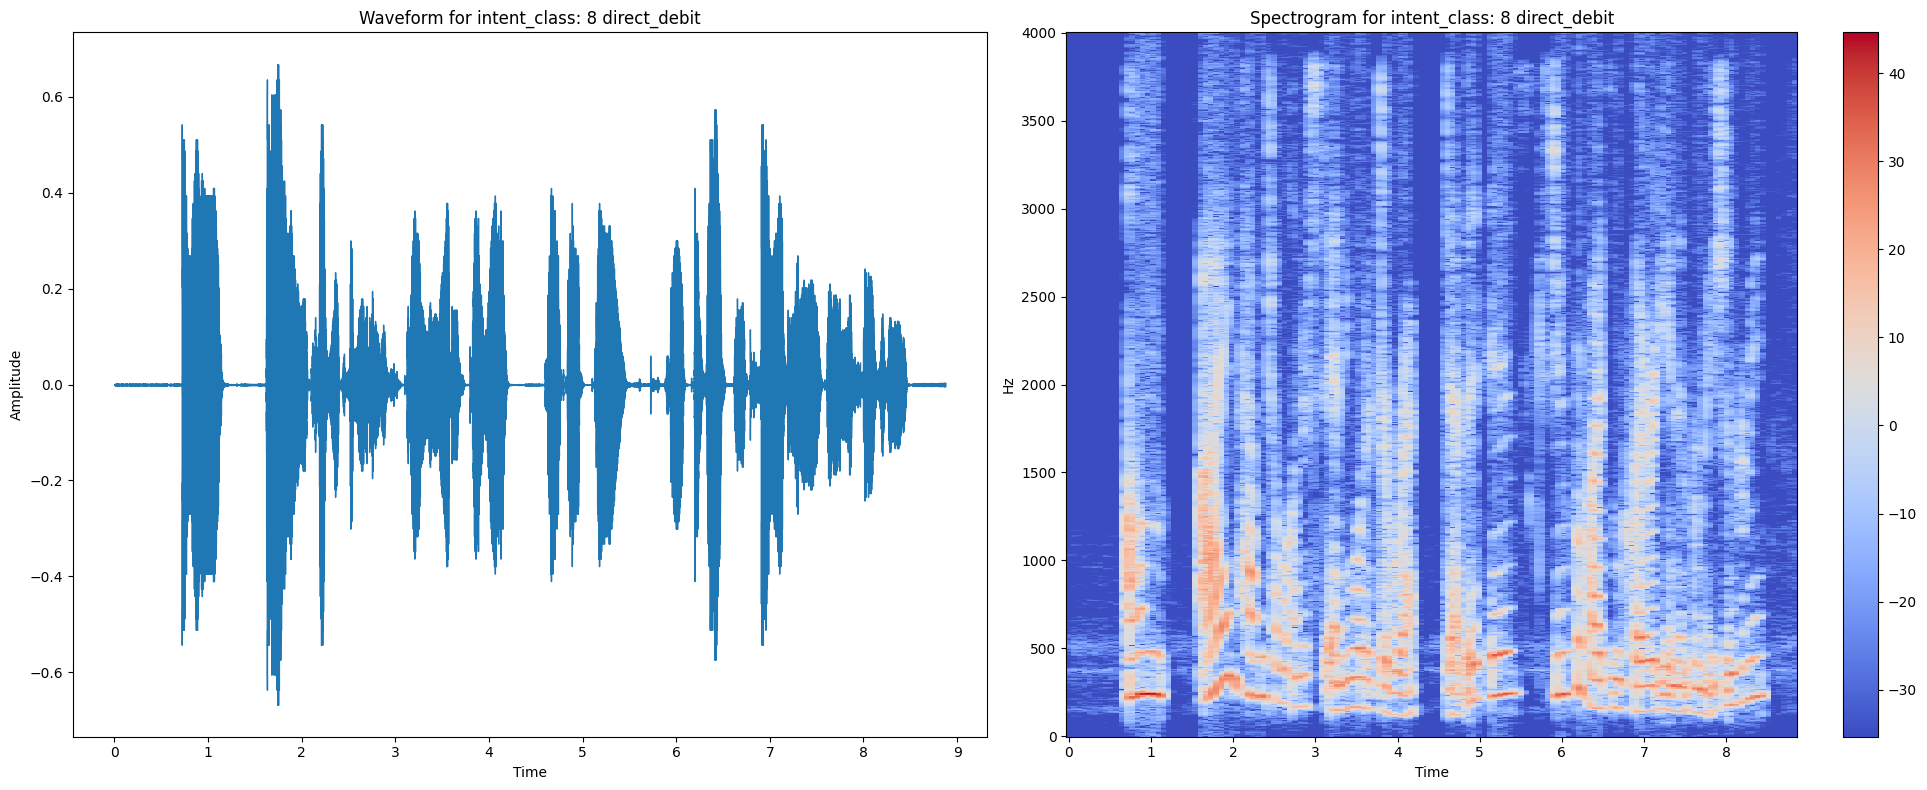

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  oh yeah hi I need fastest topical transactions on my card freeze my card block my card or something


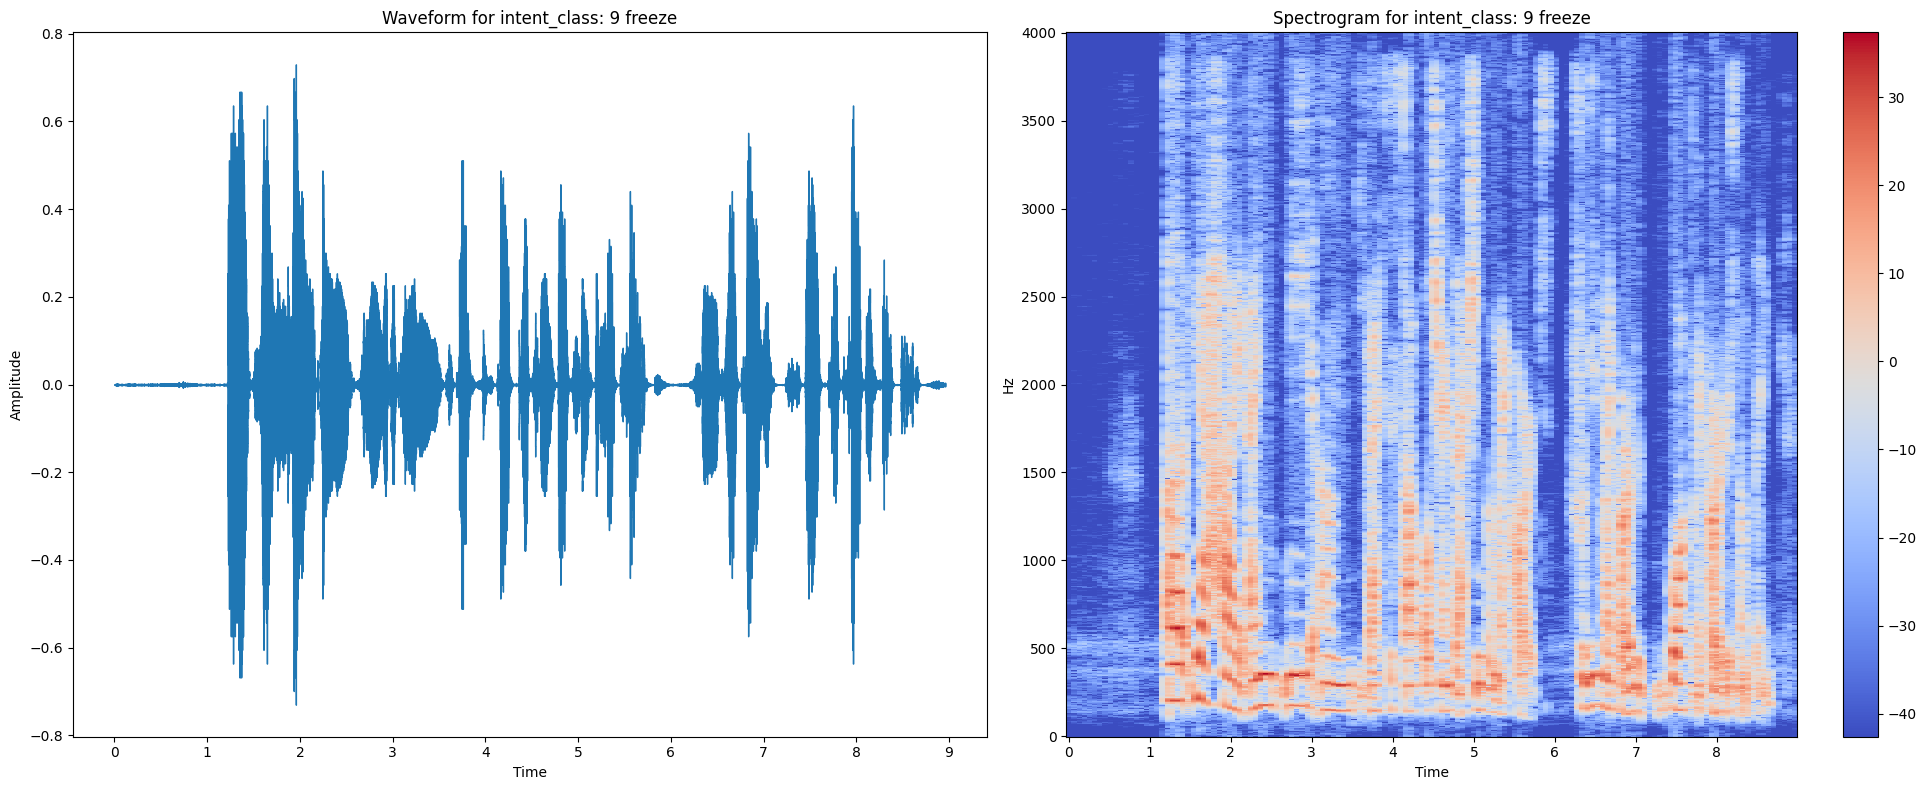

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  how do I confirm a large email with a text message


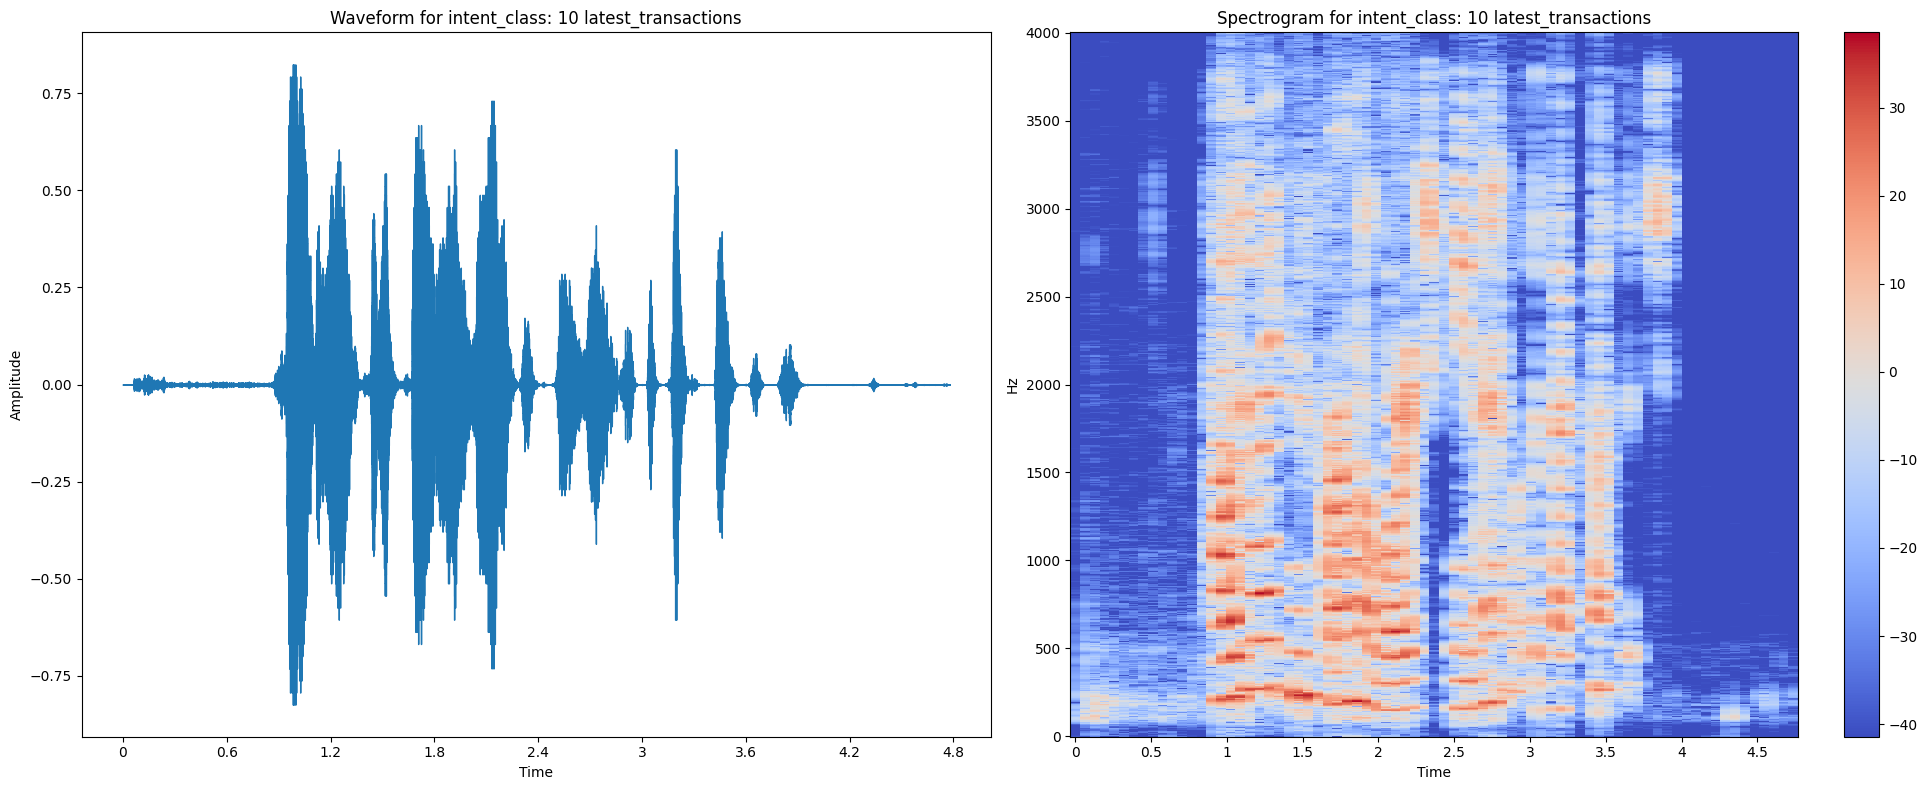

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  I would like to set up a joint account with my partner


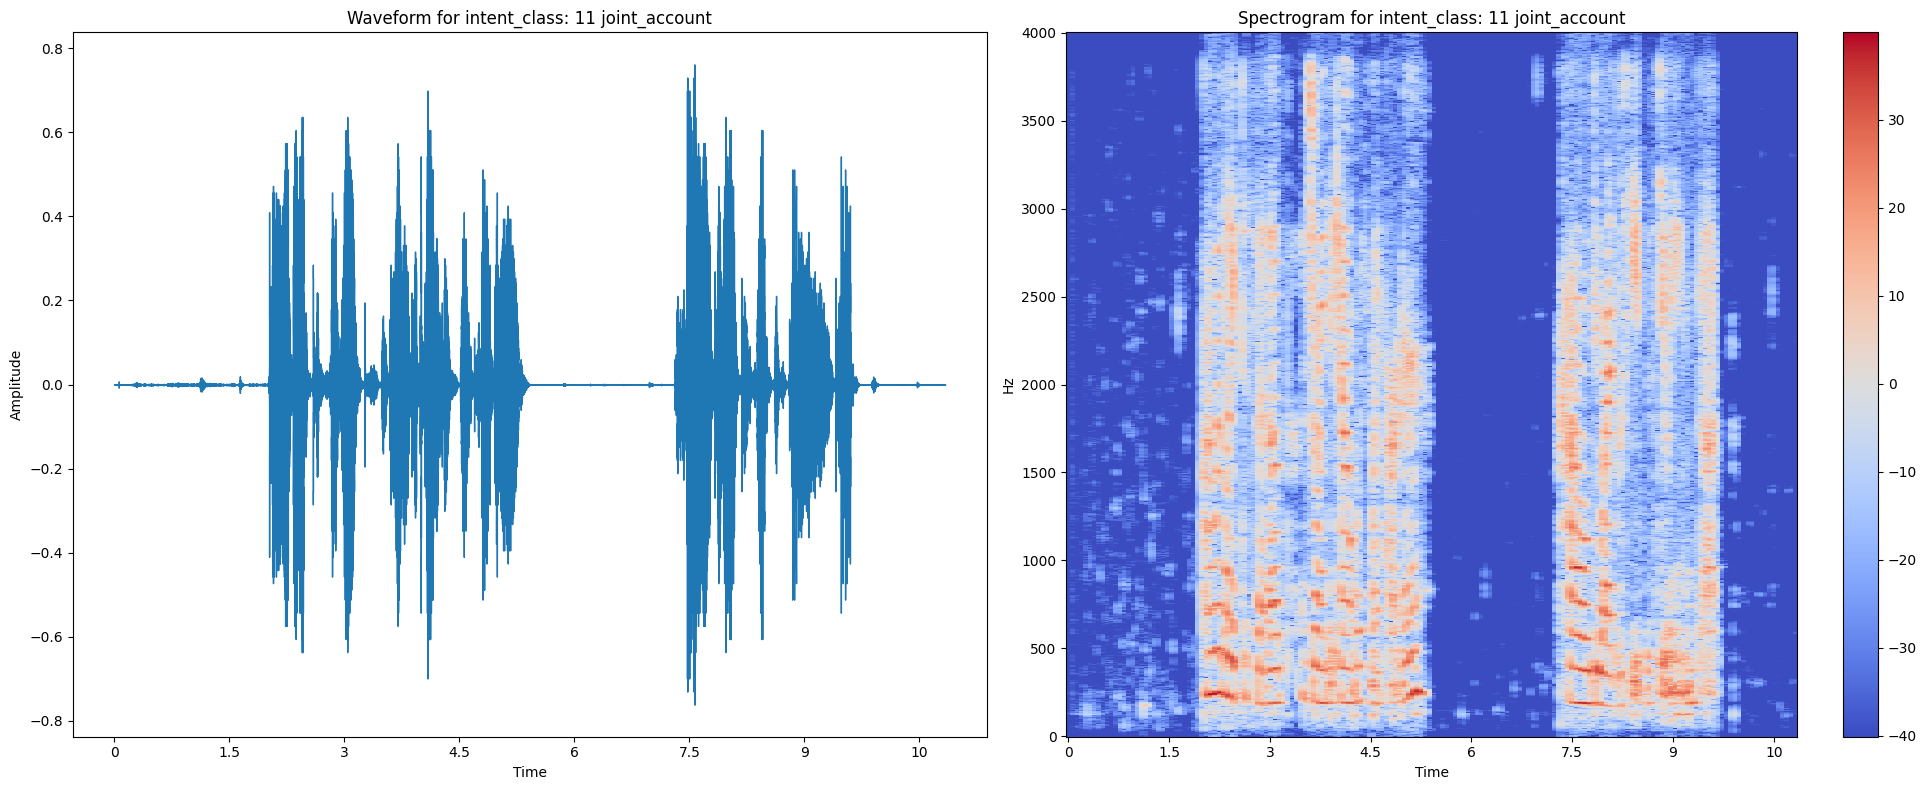

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  tell me about recent transactions on my card


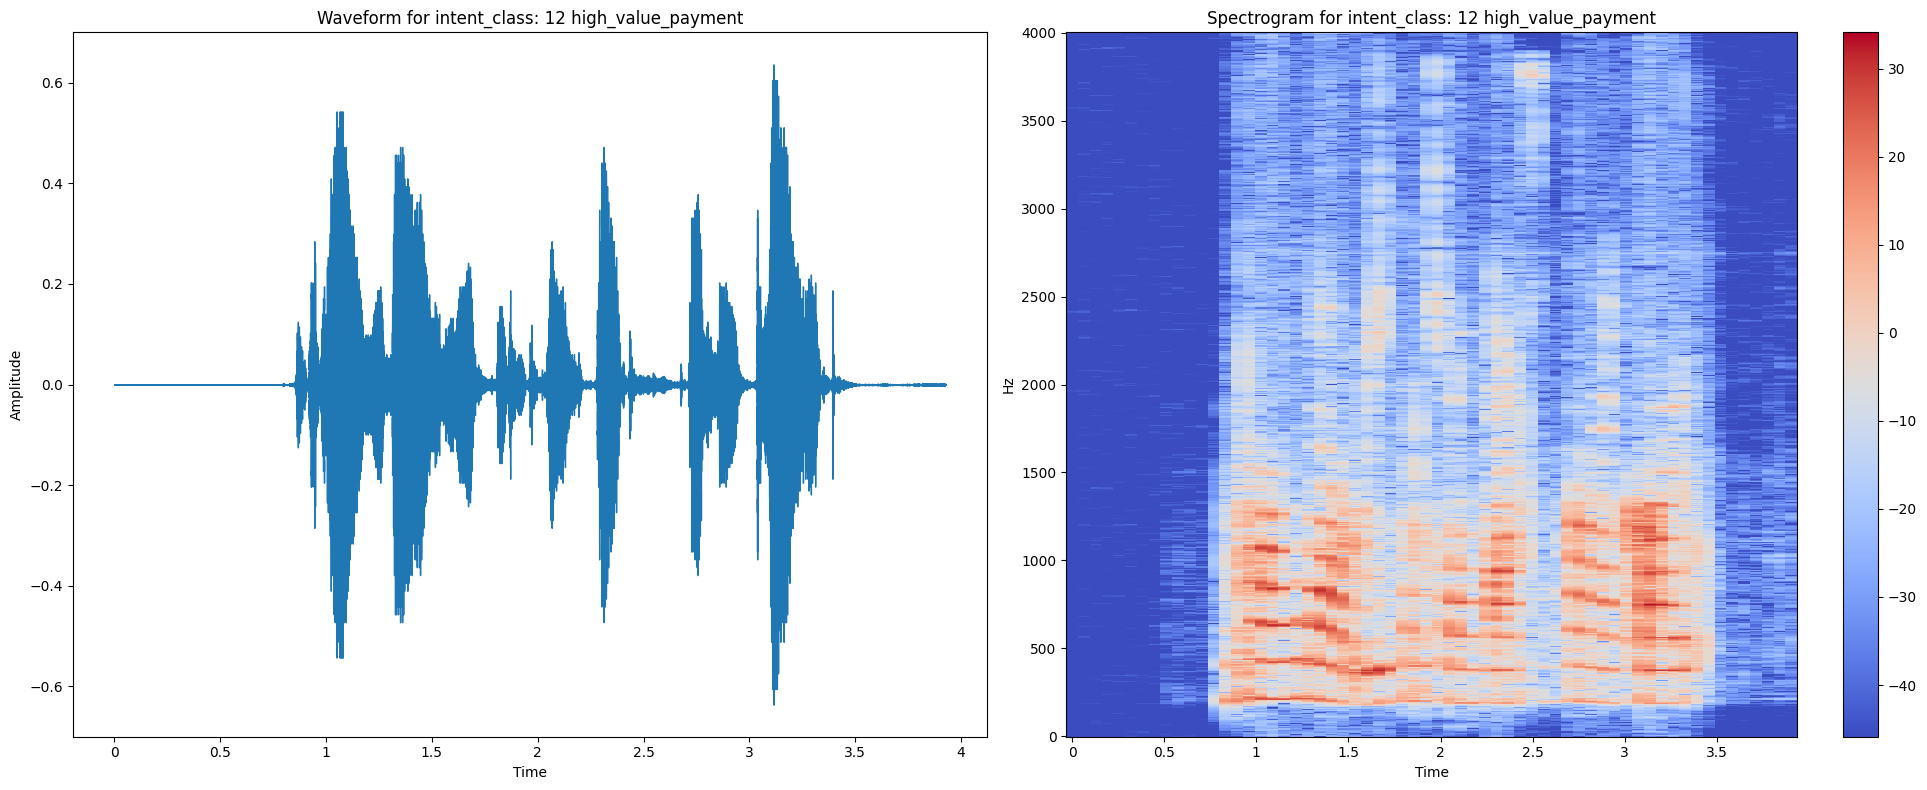

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

transcription:  I would like to make a down payment


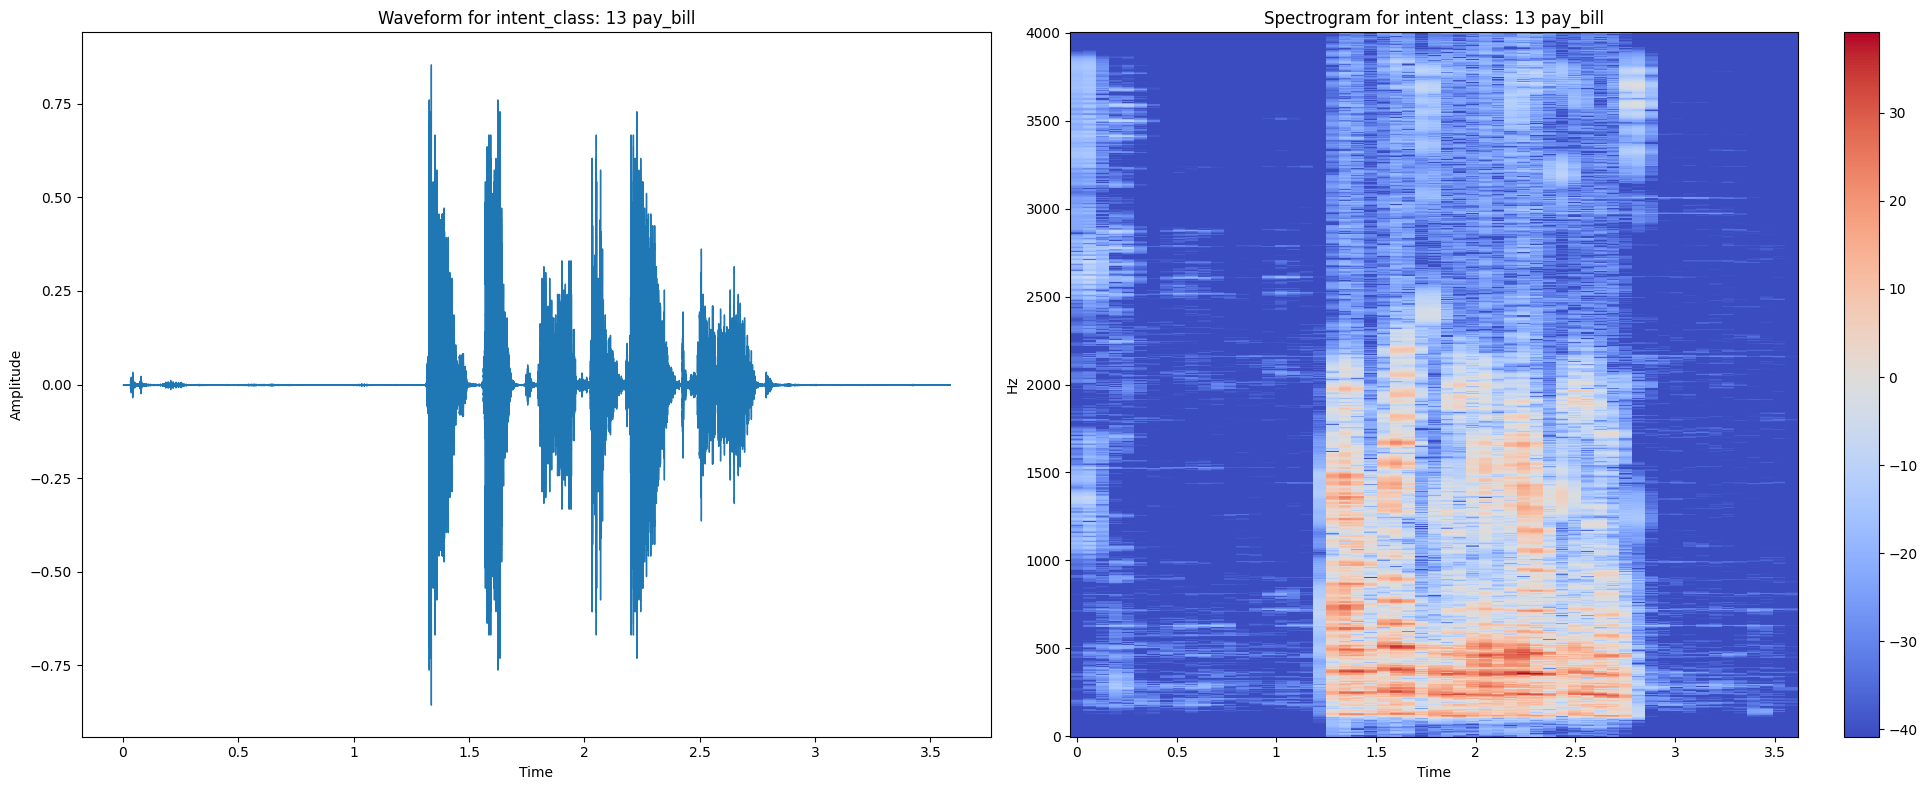

In [ ]:

for intent in range(len(intent_classes)):
  # print(intent)
  # print(intent_classes[intent]['name'])
  plot_waveform_and_spectrogram(merged_dataset, intent, intent_classes[intent]['name'])


In [ ]:
merged_dataset.features

{'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=8000, mono=True, decode=True, id=None),
 'transcription': Value(dtype='string', id=None),
 'english_transcription': Value(dtype='string', id=None),
 'intent_class': ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'], id=None),
 'lang_id': ClassLabel(names=['cs-CZ', 'de-DE', 'en-AU', 'en-GB', 'en-US', 'es-ES', 'fr-FR', 'it-IT', 'ko-KR', 'nl-NL', 'pl-PL', 'pt-PT', 'ru-RU', 'zh-CN'], id=None)}

In [ ]:
print(merged_dataset['path'][0])
print(merged_dataset['audio'][0])
print(merged_dataset['transcription'][0])
print(merged_dataset['english_transcription'][0])
print(merged_dataset['intent_class'][0])
print(merged_dataset['lang_id'][0])


/storage/hf-datasets-cache/all/datasets/51125457981586-config-parquet-and-info-PolyAI-minds14-efce24e3/downloads/extracted/cfd42a9443ffb9548ee39e3c64f8b512ca72b9ce5e2ea6b981d44ba6c7265ae8/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav
{'path': '602ba55abb1e6d0fbce92065.wav', 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
        0.        ,  0.        ]), 'sampling_rate': 8000}
I would like to set up a joint account with my partner
I would like to set up a joint account with my partner
11
4


In [ ]:
def count_feature_lengths(dataset):
    feature_lengths = {}

    for feature in dataset.features:
        values = dataset[feature]
        lengths = [len(str(value)) if not isinstance(value, (int, float, dict, list)) else 1 for value in values]
        feature_lengths[feature] = lengths
    return feature_lengths

# Count the lengths and store them
feature_lengths = count_feature_lengths(merged_dataset)

# Print the lengths for each feature
for feature, lengths in feature_lengths.items():
    print(f"{feature}: {len(lengths)}")

path: 563
audio: 563
transcription: 563
english_transcription: 563
intent_class: 563
lang_id: 563


In [ ]:
# Count the lengths and store them
feature_lengths = count_feature_lengths(minds_enUS)

# Print the lengths for each feature
for feature, lengths in feature_lengths.items():
    print(f"{feature}: {len(lengths)}")

path: 563
audio: 563
transcription: 563
english_transcription: 563
intent_class: 563
lang_id: 563


In [ ]:
def check_null_values(dataset):
    # Convert the dataset to a pandas DataFrame
    df = dataset.to_pandas()

    # Count null values for each column
    return df.isnull().sum().to_dict()

# Example usage:
null_counts = check_null_values(merged_dataset)
print(null_counts)


{'path': 0, 'audio': 0, 'transcription': 0, 'english_transcription': 0, 'intent_class': 0, 'lang_id': 0}


In [ ]:

merged_dataset


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})

In [ ]:
from collections import Counter

def check_duplicate_transcriptions(dataset):
    # Extract the transcription column
    transcriptions = dataset['transcription']

    # Count occurrences of each transcription
    transcription_counts = Counter(transcriptions)

    # Filter out transcriptions that appear more than once
    duplicates = {transcription: count for transcription, count in transcription_counts.items() if count > 1}

    return duplicates

# Example usage:
duplicates = check_duplicate_transcriptions(merged_dataset)
print(duplicates)


{'how do I set up a joint account': 3, 'what is my account balance': 2, 'show me my account balance please': 2, 'show me my account balance': 4, "what's my account balance": 2, 'I would like to make a payment': 2, "I'd like to freeze my card": 2, 'freeze my card': 2, 'I would like to change my address': 2, 'how do I change my address': 2, 'I want to change my address': 3, "I'd like to change my address": 2, 'I have a question about direct debit': 2, 'how do I deposit money into my account': 4, "I'd like to deposit money into my account": 2, "I'd like some information about a business loan": 2}


In [ ]:
len(duplicates)

16

In [ ]:
merged_dataset = merged_dataset.train_test_split(test_size=0.2)
print("split: ", merged_dataset)

merged_dataset = merged_dataset.remove_columns(
    ["english_transcription",
    "intent_class",
    "lang_id",]
)
print("remove column: ", merged_dataset)

print(merged_dataset['train']['path'][0])
print(merged_dataset['train']['audio'][0]['array'])
print(merged_dataset['train']['audio'][0]['sampling_rate'])
print(merged_dataset['train']['transcription'][0])

split:  DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})
remove column:  DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription'],
        num_rows: 113
    })
})
/storage/hf-datasets-cache/all/datasets/51125457981586-config-parquet-and-info-PolyAI-minds14-efce24e3/downloads/extracted/cfd42a9443ffb9548ee39e3c64f8b512ca72b9ce5e2ea6b981d44ba6c7265ae8/en-US~BUSINESS_LOAN/602b9c66963e11ccd901cbfd.wav
[0.00024414 0.00024414 0.         ... 0.00024414 0.00024414 0.        ]
8000
I was calling to ask about a business loan


In [ ]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))


show_random_elements(dataset=merged_dataset['train'].remove_columns(['audio', 'path']), num_examples=10)

In [ ]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["transcription"] = re.sub(chars_to_ignore_regex, '', batch["transcription"]).lower() + " "
    batch["transcription"] = batch['transcription'].rstrip()
    return batch

merged_dataset = merged_dataset.map(remove_special_characters)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

In [ ]:
show_random_elements(dataset=merged_dataset['train'].remove_columns(['audio', 'path']), num_examples=10)

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["transcription"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = merged_dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=1,
    keep_in_memory=True,
    remove_columns=merged_dataset.column_names['train']
)

vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
print(vocab_dict)

vocab_dict["|"] = vocab_dict[" "]
del vocab_dict [" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))


Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

{'g': 0, 's': 1, 't': 2, 'y': 3, 'd': 4, 'n': 5, 'e': 6, 'h': 7, 'k': 8, 'v': 9, 'c': 10, 'u': 11, 'w': 12, 'm': 13, 'a': 14, 'r': 15, 'l': 16, 'i': 17, 'o': 18, "'": 19, ' ': 20, 'b': 21, 'p': 22}
25


In [ ]:
import IPython.display as ipd

In [ ]:
rand_int = random.randint(0, len(merged_dataset['train']))

print(merged_dataset['train'][rand_int]['transcription'])
ipd.Audio(data=np.asarray(merged_dataset['train'][rand_int]['audio']['array']), autoplay=True, rate=8000)

see my latest transactions


In [ ]:
rand_int = random.randint(0, len(merged_dataset['train']))

print(merged_dataset['train'][rand_int]['transcription'])
ipd.Audio(data=np.asarray(merged_dataset['train'][rand_int]['audio']['array']), autoplay=True, rate=16000)

freeze my card


In [ ]:
from datasets import Audio

merged_dataset = merged_dataset.cast_column("audio", Audio(sampling_rate=16_000))
merged_dataset['train'][0]

{'path': '/storage/hf-datasets-cache/all/datasets/51125457981586-config-parquet-and-info-PolyAI-minds14-efce24e3/downloads/extracted/cfd42a9443ffb9548ee39e3c64f8b512ca72b9ce5e2ea6b981d44ba6c7265ae8/en-US~BUSINESS_LOAN/602b9c66963e11ccd901cbfd.wav',
 'audio': {'path': '602b9c66963e11ccd901cbfd.wav',
  'array': array([ 2.26674281e-04,  3.08584742e-04,  2.64169619e-04, ...,
          1.27390027e-04, -2.77563231e-07, -3.74693336e-05]),
  'sampling_rate': 16000},
 'transcription': 'i was calling to ask about a business loan'}

In [ ]:
ipd.Audio(data=np.asarray(merged_dataset['train'][0]['audio']['array']), autoplay=True, rate=16000)

In [ ]:
whisper = 'sumet/whisper-tiny-en-US'

tokenizer = WhisperTokenizer.from_pretrained(whisper, language="english")
feature_extractor = WhisperFeatureExtractor.from_pretrained(whisper)
processor = WhisperProcessor(
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    )

model = WhisperForConditionalGeneration.from_pretrained(whisper)
model.config.forced_decoder_ids = None


tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

In [ ]:
merged_dataset['train']['audio'][0]['sampling_rate']

16000

In [ ]:
audio_array = merged_dataset['train']['audio'][0]['array']
audio_sr = merged_dataset['train']['audio'][0]['sampling_rate']
audio_text = merged_dataset['train']['transcription'][0]

encoded_input = processor(
    audio_array,
    sampling_rate=audio_sr,
    return_tensors='pt',
).input_features

encoded_label = processor(
    text=audio_text,
    return_tensors='pt',
).input_ids

print("array: ", audio_array)
print("text: ", audio_text)
print("#"*50)
print("feature: ", encoded_input)
print("label: ", encoded_label)

array:  [ 2.26674281e-04  3.08584742e-04  2.64169619e-04 ...  1.27390027e-04
 -2.77563231e-07 -3.74693336e-05]
text:  i was calling to ask about a business loan
##################################################
feature:  tensor([[[-0.7668, -0.7293, -0.4278,  ..., -0.8408, -0.8408, -0.8408],
         [-0.8408, -0.8408, -0.3879,  ..., -0.8408, -0.8408, -0.8408],
         [-0.7263, -0.8408, -0.4029,  ..., -0.8408, -0.8408, -0.8408],
         ...,
         [-0.8408, -0.8408, -0.8408,  ..., -0.8408, -0.8408, -0.8408],
         [-0.8408, -0.8408, -0.8408,  ..., -0.8408, -0.8408, -0.8408],
         [-0.8408, -0.8408, -0.8408,  ..., -0.8408, -0.8408, -0.8408]]])
label:  tensor([[50258, 50259, 50363,    72,   390,  5141,   220,  1353,  1029,   466,
           257,  1606, 10529, 50257]])


In [ ]:
predicted_ids = model.generate(encoded_input)

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.


In [ ]:
decoded_predict = processor.batch_decode(predicted_ids, skip_special_tokens=True)
decoded_label = processor.batch_decode(encoded_label, skip_special_tokens=True)

print("decoded predict: ", decoded_predict)
print("decoded label: ", decoded_label)

decoded predict:  [' I was calling to ask about a business loan']
decoded label:  ['i was calling to ask about a business loan']


In [ ]:
def prepare_datasets(batch):
  audio = batch['audio']

  batch = processor(
      audio=audio['array'],
      sampling_rate=audio['sampling_rate'],
      text=batch['transcription'],
  )

  batch['input_length'] = len(audio['array']) / audio['sampling_rate']

  return batch

encoded_datasets = merged_dataset.map(
    prepare_datasets,
    remove_columns=merged_dataset.column_names['train'],
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/450 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/113 [00:00<?, ? examples/s]

In [ ]:
print(encoded_datasets)


DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 450
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 113
    })
})


In [ ]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
metric_wer = evaluate.load("wer")

In [ ]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
# from nltk.translate import rouge_score
from rouge import Rouge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score, r2_score

normalizer = BasicTextNormalizer()
smoother = SmoothingFunction()

rouge_score = Rouge()

def compute_f1(preds, labels):
    # Convert predictions and labels to binary (0 or 1)
    preds_binary = [1 if p == l else 0 for p, l in zip(preds, labels)]
    labels_binary = [1 if l != processor.tokenizer.pad_token_id else 0 for l in labels]  # Assuming padding token ID is used for no label

    return f1_score(labels_binary, preds_binary)

def compute_r2(preds, labels):
    # try:
    #     # Convert strings to floating-point numbers
    #     preds_float = np.array([float(p) for p in preds])
    #     labels_float = np.array([float(l) for l in labels])

    #     # Calculate R2 score
    #     return r2_score(labels_float, preds_float)
    # except ValueError as e:
    #     print(f"Error: {e}")
    #     return None
    return r2_score(labels, preds)

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Word Error Rate (WER)
    wer_ortho = 100 * metric_wer.compute(predictions=pred_str, references=label_str)

    # Normalized WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]

    wer = metric_wer.compute(predictions=pred_str_norm, references=label_str_norm)

    # Accuracy
    correct_preds = sum(1 for p, l in zip(pred_str_norm, label_str_norm) if p == l)
    total_preds = len(pred_str_norm)
    accuracy = correct_preds / total_preds

    # ROUGE Metrics
    rouge_scores = rouge_score.get_scores(pred_str_norm, label_str_norm, avg=True)

    # F1 Score, R2,
    # (Assuming you have the necessary functions or metrics for these calculations)
    f1_score = compute_f1(pred_str_norm, label_str_norm)
    r2_score = compute_r2(pred_ids, label_ids)

    # BLEU Score
    references = [[ref.split()] for ref in label_str_norm]
    predictions = [pred.split() for pred in pred_str_norm]
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoother.method1)

    return {
        "wer_ortho": wer_ortho,
        "wer": wer,
        "accuracy": accuracy,
        "f1_score": f1_score,
        "r2_score": r2_score,
        "bleu_score": bleu_score,
        "Rouge 1 r": rouge_scores['rouge-1']['r'],
        "Rouge 1 p": rouge_scores['rouge-1']['p'],
        "Rouge 1 f": rouge_scores['rouge-1']['f'],
    }


In [ ]:
from functools import partial

model.config.use_cache = False
model.generate = partial(
    model.generate,
    language="english",
    task="transcribe",
    use_cache=True,
)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-tiny-minds14-enUS",
    # num_train_epochs=4,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=3e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=400,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=400,
    eval_steps=400,
    logging_steps=400,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    args= training_args,
    model=model,
    train_dataset=encoded_datasets['train'],
    eval_dataset=encoded_datasets['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    # optimizers=optimizer, # default optimizer is AdamW
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.

TrainOutput(global_step=4000, training_loss=0.05498223556892481, metrics={'train_runtime': 9056.6097, 'train_samples_per_second': 7.067, 'train_steps_per_second': 0.442, 'total_flos': 1.52838962601984e+18, 'train_loss': 0.05498223556892481, 'epoch': 137.93103448275863})

In [ ]:
saved_model_pt = "whisper-minds14-enUS"

trainer.save_model(saved_model_pt)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


In [ ]:
# prompt: download the model into my local

from google.colab import files
import os

# Replace with the actual path to your saved model directory
saved_model_pt = "whisper-minds14-enUS"

# Create a zip file of the model directory
!zip -r {saved_model_pt}.zip {saved_model_pt}

# Download the zip file
files.download(f'{saved_model_pt}.zip')

  adding: whisper-minds14-enUS/ (stored 0%)
  adding: whisper-minds14-enUS/tokenizer_config.json (deflated 94%)
  adding: whisper-minds14-enUS/vocab.json (deflated 69%)
  adding: whisper-minds14-enUS/added_tokens.json (deflated 74%)
  adding: whisper-minds14-enUS/config.json (deflated 62%)
  adding: whisper-minds14-enUS/training_args.bin (deflated 51%)
  adding: whisper-minds14-enUS/special_tokens_map.json (deflated 80%)
  adding: whisper-minds14-enUS/model.safetensors (deflated 8%)
  adding: whisper-minds14-enUS/preprocessor_config.json (deflated 42%)
  adding: whisper-minds14-enUS/normalizer.json (deflated 81%)
  adding: whisper-minds14-enUS/generation_config.json (deflated 71%)
  adding: whisper-minds14-enUS/merges.txt (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EVALUATE

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
smoother = SmoothingFunction()

In [ ]:
audio_file = merged_dataset['test']['audio'][0]
target = merged_dataset['test']['transcription'][0]
device = "cuda:0" if torch.cuda.is_available() else "cpu"

transcriber = pipeline(
    "automatic-speech-recognition",
    model=saved_model_pt,
    chunk_length_s=30,
    device=device,
)


In [ ]:
prediction = transcriber(
    audio_file,
    batch_size=8,
    return_timestamps=True,
)['chunks']

print("timestamp: ", prediction[0]['timestamp'])
print("predict: ", prediction[0]['text'])
print("target: ", target)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


timestamp:  (0.0, None)
predict:  hi i'm having an issue with your app i'm actually having a issue with it coming up on my phone and being able to go all again could you please help me with this
target:  hi i'm having issue with your app coming up on my phone and being able to walk again


In [ ]:
def predict_eval(audio_file, target, idx):
    preds = transcriber(
        audio_file,
        batch_size=8,
    )['text']

    # print("preds: ", preds)
    # print("target: ", target)

    pred_words = preds.split(" ")
    ref_words = target.split(" ")

    # Remove any empty strings from the end of the lists
    if pred_words[-1] == '':
        pred_words = pred_words[:-1]
    if ref_words[-1] == '':
        ref_words = ref_words[:-1]

    # Pad the shorter sequence with empty strings
    max_length = max(len(pred_words), len(ref_words))
    pred_words += ['PAD'] * (max_length - len(pred_words))
    ref_words += ['PAD'] * (max_length - len(ref_words))

    # encoded_text = processor(preds, text=target, sampling_rate=16000)

    # print(len(pred_words))
    # print(len(ref_words))
    # print(pred_words)
    # print(ref_words)

    # Check if both prediction and reference are non-empty
    if pred_words and ref_words:
        wer = metric_wer.compute(predictions=pred_words, references=ref_words)
        wer_percentage = wer * 100
    else:
        wer_percentage = 0.0  # or any other default value

    # Compute accuracy
    correct = sum(1 for p, r in zip(pred_words, ref_words) if p == r)
    accuracy = (correct / len(pred_words)) * 100

    # Compute ROUGE Metrics
    rouge_scores = rouge_score.get_scores(preds, target, avg=True)

    f1 = compute_f1(pred_words, ref_words)

    # BLEU Score
    references = [[ref.split()] for ref in ref_words]
    predictions = [pred.split() for pred in pred_words]
    bleu = corpus_bleu(references, predictions, smoothing_function=smoother.method1)
    return {
        "num": idx,
        "wer": wer,
        "werotho": f"{wer_percentage:.2f}%",
        "accuracy": accuracy,
        "f1_score": f1,
        "bleu_score": bleu,
        "Rouge 1 r": rouge_scores['rouge-1']['r'],
        "Rouge 1 p": rouge_scores['rouge-1']['p'],
        "Rouge 1 f": rouge_scores['rouge-1']['f'],
        "predict": preds,
        "target": target,
    }



preds_eval_list = []

for idx in range(len(merged_dataset['test'])):

  predicted = predict_eval(merged_dataset['test']['audio'][idx], merged_dataset['test']['transcription'][idx], idx)
  preds_eval_list.append(predicted)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is

In [ ]:
# prompt: save all the result from testing

import pandas as pd

# Assuming preds_eval_list is already populated from the previous code
df = pd.DataFrame(preds_eval_list)

# Save the DataFrame to a CSV file
df.to_csv('evaluation_results.csv', index=False)

# Download the CSV file (requires the files module from google.colab)
from google.colab import files
files.download('evaluation_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result = pd.read_csv("/content/evaluation_results.csv")
result

num       wer  werotho    accuracy  f1_score  bleu_score  Rouge 1 r  \
0      0  0.911765   91.18%    8.823529  0.162162    0.006883   0.944444   
1      1  0.882353   88.24%   11.764706  0.210526    0.012440   0.533333   
2      2  0.000000    0.00%  100.000000  1.000000    0.031623   1.000000   
3      3  0.000000    0.00%  100.000000  1.000000    0.041322   1.000000   
4      4  0.058824    5.88%   94.117647  0.969697    0.020921   0.941176   
..   ...       ...      ...         ...       ...         ...        ...   
108  108  1.000000  100.00%    0.000000  0.000000    0.000000   0.714286   
109  109  1.000000  100.00%    0.000000  0.000000    0.000000   1.000000   
110  110  0.000000    0.00%  100.000000  1.000000    0.078012   1.000000   
111  111  0.806452   80.65%   19.354839  0.324324    0.008978   0.863636   
112  112  0.090909    9.09%   90.909091  0.952381    0.028748   0.909091   

     Rouge 1 p  Rouge 1 f                                            predict  \
0     0.586207   0.723404  hi i'm having an issue with your app i'm actua...   
1     0.533333   0.533333  hello i'm calling because i was wondering if i...   
2     1.000000   1.000000   how do i go about depositing money in my account   
3     1.000000   1.000000                     i would like to make a payment   
4     0.941176   0.941176  hello i'm calling to pay for my electric and w...   
..         ...        ...                                                ...   
108   0.625000   0.666667          can't use my card because it doesn't work   
109   0.916667   0.956522  hey i'd like to put some money into my checkin...   
110   1.000000   1.000000                                  change my address   
111   0.826087   0.844444  hi there i want to pay bill i have a particula...   
112   0.909091   0.909091  how much money can i withdraw per day from me atm   

                                                target  
0    hi i'm having issue with your app coming up on...  
1    hello i'm going to see if i would want to give...  
2     how do i go about depositing money in my account  
3                       i would like to make a payment  
4    hello i'm calling to pay for my electric and w...  
..                                                 ...  
108                  is my car because it doesn't work  
109  i'd like to put some money into my checking ac...  
110                                  change my address  
111  yeah i know i want to pay bill i have a partic...  
112  how much money can i withdraw per day from the...  

[113 rows x 11 columns]

In [ ]:
accuracy_values = [entry['accuracy'] for entry in preds_eval_list]
overall_accuracy = sum(accuracy_values) / len(accuracy_values)

print(f"Overall Accuracy: {overall_accuracy:.2f}%")

Overall Accuracy: 62.25%


In [ ]:
wer_values = [entry['wer'] for entry in preds_eval_list]
overall_wer = sum(wer_values) / len(wer_values)

print(f"Overall WER: {overall_wer:.2f}%")

Overall WER: 0.38%


In [ ]:
f1_values = [entry["f1_score"] for entry in preds_eval_list]
overall_f1 = sum(f1_values) / len(f1_values)

print(overall_f1)

0.6722310125665265


In [ ]:
bleu_values = [entry["bleu_score"] for entry in preds_eval_list]
overall_bleu = sum(bleu_values) / len(bleu_values)

print(overall_bleu)

0.02350707249470183


# trial using model uploaded in huggingface

In [ ]:
# prompt: make a code to generate result based on the model in huggingface

from transformers import pipeline

# Replace with your Hugging Face model ID
model_id = "kairaamilanii/whisper-mind14-enUS"

# Create a pipeline for automatic speech recognition
transcriber = pipeline(
    "automatic-speech-recognition",
    model=model_id,
    chunk_length_s=30,
    device="cuda:0" if torch.cuda.is_available() else "cpu",
)

# Example usage: transcribe an audio file
audio_file = "/content/602b9a90963e11ccd901cbd0.wav"  # Replace with your audio file path
text = transcriber(audio_file)

text

config.json:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


{'text': "hello i was looking at my recent transactions and i saw that there's a payment that i didn't make will you be able to stop this thank you"}

In [ ]:
ipd.Audio(data='/content/602b9a90963e11ccd901cbd0.wav', autoplay=True, rate=16000)